In [3]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import seaborn as sns

In [4]:
df=pd.read_csv("Data/labels_one_hot.csv")

/var/folders/sk/5p85qfdj4gs6687j53mbs7rw0000gn/T/ipykernel_18610/147562193.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.drop(columns=['image']).columns, y=df.drop(columns=['image']).sum(),palette='colorblind')


<Axes: xlabel='None', ylabel='None'>

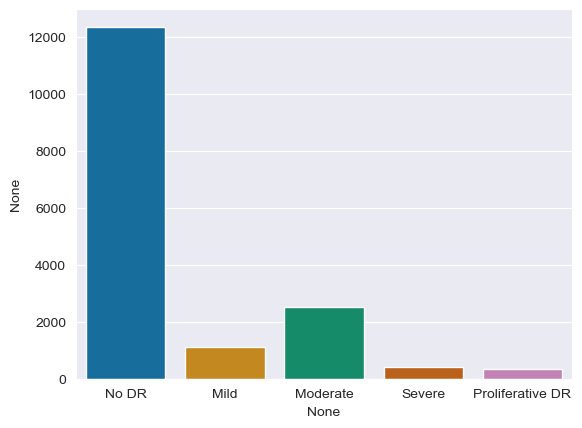

In [3]:
sns.barplot(x=df.drop(columns=['image']).columns, y=df.drop(columns=['image']).sum(),palette='colorblind')

In [5]:
df.sum()

image               1763_left18113_right1887_left14060_left18880_l...
No DR                                                           12355
Mild                                                             1126
Moderate                                                         2525
Severe                                                            422
Proliferative DR                                                  324
dtype: object

In [6]:
Train_X,Test_X,Train_Y,Test_Y=train_test_split(df['image'],df,test_size=0.2,random_state=27)

In [10]:
Train_Y.sum()

image               26902_right15443_left16260_left14386_left13739...
No DR                                                            9929
Mild                                                              896
Moderate                                                         1991
Severe                                                            337
Proliferative DR                                                  248
dtype: object

In [ ]:
Test_Y.value_counts()

In [7]:
condition = (Train_Y['No DR'] == 1)
rows_to_remove = Train_Y[condition].sample(frac=0.4, random_state=42).index

In [8]:
Train_Y=Train_Y.drop(rows_to_remove)

In [9]:
Train_X=Train_Y['image']

In [13]:
Train_X

2634      15443_left
2395      16260_left
7403      13739_left
4052      10823_left
3515     13125_right
            ...     
15897     10233_left
4848      14262_left
14879     26024_left
3912       184_right
5139      15450_left
Name: image, Length: 9429, dtype: object

In [19]:
train_images=[]
for img in Train_X:
    train_images.append(cv2.imread("Data/preprocessed/"+img+".jpg"))

In [23]:
Train_Y.reset_index(drop=True,inplace=True)

In [47]:
i=0
j=0
k=0
train_images_oversampling=[img for img in train_images]
train_y_oversampling=Train_Y.copy()

In [48]:
train_y_oversampling.sum()

image               15443_left16260_left13739_left10823_left13125_...
No DR                                                            5957
Mild                                                              896
Moderate                                                         1991
Severe                                                            337
Proliferative DR                                                  248
dtype: object

In [49]:
for index in range(0,len(Train_Y)):
  if i<300 and Train_Y['Proliferative DR'][index]==1:
    train_images_oversampling.append(train_images[index])
    new_row={
             'No DR':Train_Y['No DR'][index],'Mild':Train_Y['Mild'][index], 
             'Moderate':Train_Y['Moderate'][index],
             'Severe':Train_Y['Severe'][index],
             'Proliferative DR':Train_Y['Proliferative DR'][index]}
    train_y_oversampling=train_y_oversampling._append(new_row,ignore_index=True)
    i=i+1
  if j<500 and Train_Y['Severe'][index]==1:
    train_images_oversampling.append(train_images[index])
    new_row={
             'No DR':Train_Y['No DR'][index],'Mild':Train_Y['Mild'][index], 
             'Moderate':Train_Y['Moderate'][index],
             'Severe':Train_Y['Severe'][index],
             'Proliferative DR':Train_Y['Proliferative DR'][index]}
    train_y_oversampling=train_y_oversampling._append(new_row,ignore_index=True)
    j=j+1
  if k<700 and Train_Y['Mild'][index]==1:
    train_images_oversampling.append(train_images[index])
    new_row={
             'No DR':Train_Y['No DR'][index],'Mild':Train_Y['Mild'][index], 
             'Moderate':Train_Y['Moderate'][index],
             'Severe':Train_Y['Severe'][index],
             'Proliferative DR':Train_Y['Proliferative DR'][index]}
    train_y_oversampling=train_y_oversampling._append(new_row,ignore_index=True)
    k=k+1
  if k>700 and i>300 and j>500:
    break
  

In [38]:
import random
import math
index_augmentation_4=[i for i in range(0,len(train_y_oversampling)) if train_y_oversampling['Proliferative DR'][i]==1]
index_augmentation_3=[i for i in range(0,len(train_y_oversampling)) if train_y_oversampling['Severe'][i]==1]
index_augmentation_2=[i for i in range(0,len(train_y_oversampling)) if train_y_oversampling['Moderate'][i]==1]
index_augmentation_2=random.sample(index_augmentation_2, min(math.ceil(len(index_augmentation_2)*0.7), len(index_augmentation_2)))
index_augmentation_1=[i for i in range(0,len(train_y_oversampling)) if train_y_oversampling['Mild'][i]==1]

In [58]:
train_y_oversampling.sum()

No DR               5957
Mild                1596
Moderate            1991
Severe               674
Proliferative DR     496
dtype: int64

In [61]:
def data_augmentation(index):
    img = train_images_oversampling[index]
    angle = np.random.uniform(-20, 20)
    rotation_matrix = cv2.getRotationMatrix2D((img.shape[1] // 3, img.shape[0] // 3), angle, 1.0)
    img = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))
    new_row={'No DR':train_y_oversampling['No DR'][index],'Mild':train_y_oversampling['Mild'][index], 'Moderate':train_y_oversampling['Moderate'][index],'Severe':train_y_oversampling['Severe'][index], 'Proliferative DR':train_y_oversampling['Proliferative DR'][index]}
    train_images_oversampling.append(img)
    return new_row

In [62]:
for subset in [index_augmentation_1,index_augmentation_2,index_augmentation_3,index_augmentation_4]:
    for index in subset:
        train_y_oversampling=train_y_oversampling._append(data_augmentation(index),ignore_index=True)

In [44]:
train_y_oversampling.drop(columns=['image'],inplace=True)
Test_Y.drop(columns=['image'],inplace=True)

In [63]:
train_y_oversampling.sum()

No DR               5957
Mild                3192
Moderate            3385
Severe              1348
Proliferative DR     992
dtype: int64

In [86]:
np.save("Train_X_whole.npy",np.array(train_images_oversampling))


In [87]:
train_y_oversampling.to_csv("Train_Y_whole.csv",index=False)

In [36]:
test_images=[]
for img in Test_X:
    test_images.append(cv2.imread("Data/preprocessed/"+img+".jpg"))

In [37]:
np.save("Test_X_2.npy",np.array(test_images))

Test_Y.to_csv("Test_Y_2.csv",index=False)